# Capstone Project - Movie Recommendations for New Users
*Catherine Hocknell* | 10 April, 2023

##### Notebook 5/5

This notebook will cover the user based recommender systems that have been generated from the *Reviews* dataset, looking both at recommending movies based on what other users have also liked, and also recommending movies to users based on what a reviewer with similar interests has enjoyed in the past. 

---
# User Based & Collaborative Recommender Systems

In [1]:
# basic python
import numpy as np
import pandas as pd

#graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# funkSVD
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise import accuracy
from surprise.model_selection import train_test_split

#warnings
import warnings
warnings.filterwarnings('ignore')

# 0 Data Import
The data required for this notebook is contained within the following .csv files:

|Filename|Description|
|-|-|
|reviews_for_vectorizing_full.csv|Final reviews dataset including only english reviews with a numeric score after NLP pre-processing|
|rotten_tomatoes_movies.csv|Full movies dataset from Kaggle|

These files are imported and assigned to dataframes below.

# 1 Exploratory Data Analysis
## 1.1 Review Cleaning
The first stage to consider is to look into the datasets that will be used, which in this case is **both** the full movie dataset and the reviews dataset (which is the cleaned output from the *Data Wrangling* notebook). These are imported below.

In [2]:
# import table containing all reviews that have been cleaned and tokenised for the sentiment analysis
clean_df = pd.read_csv('data/reviews_for_vectorizing_full.csv', index_col = 0)
fullmovies_df = pd.read_csv('data/rotten_tomatoes_movies.csv')

Within the *Data Wrangling* notebook, five instances have been found where the rotten tomatoes links are not common between the *movies* database and the *reviews* database. These have been replaced within `clean_df` with the corrrect links below, which will allow for the tables to be joined when needed.

In [3]:
# rename movie links
clean_df['rotten_tomatoes_link'] = clean_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/+_one_2019','m/plus_one_2019'))
clean_df['rotten_tomatoes_link'] = clean_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/+h','m/plush'))
clean_df['rotten_tomatoes_link'] = clean_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/-_man','m/minus_man'))
clean_df['rotten_tomatoes_link'] = clean_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/-cule_valley_of_the_lost_ants','m/minuscule_valley_of_the_lost_ants'))
clean_df['rotten_tomatoes_link'] = clean_df['rotten_tomatoes_link'].apply(lambda x: x.replace('m/sympathy-for-the-devil-one-+-one','m/sympathy-for-the-devil-one-plus-one'))

In [4]:
# sanity check
clean_df[clean_df['rotten_tomatoes_link'].str.contains('plus_one')].head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score,review_length,stemmed,stem_str,review_type_calc
658840,m/plus_one_2019,Joey Magidson,False,AwardsCircuit.com,1,3/4,2019-05-08,This charming rom com goes to a lot of expecte...,3.0,4,0.75,31,"['charm', 'rom', 'com', 'goe', 'lot', 'expect'...",charm rom com goe lot expect place though appe...,1


In order to create recommender systems based on the users, a reduced dataframe is created containing only the movie reference, critic name and score of the review (which is located via the index column). This is created below.

In [5]:
# Create smaller df to be used in recommender system
small_df = clean_df[['rotten_tomatoes_link', 'critic_name', 'final_score']]
small_df.head()

,rotten_tomatoes_link,critic_name,final_score
3,m/0814255,Ben McEachen,0.70
6,m/0814255,Nick Schager,0.25
7,m/0814255,Bill Goodykoontz,0.70
9,m/0814255,Jim Schembri,0.60
10,m/0814255,Mark Adams,0.80


In [6]:
# sanity check
small_df.shape

(541937, 3)

This dataset is then reviewed for any null values.

In [7]:
print(f'The dataset contains {small_df.isna().sum().sum()} null values.')

The dataset contains 0 null values.


## 1.2 Filter Reviewers

In order to complete a user based recommendation system, a numeric id for each of the critics must be created. First, the number of reviews made by each reviewer will be observed by creating a new `critics_df` dataframe.

In [8]:
# count number of reviews made by each critic
critics_df = pd.DataFrame(small_df['critic_name'].value_counts()).reset_index()

#rename columns
critics_df.columns = ['critic_name', 'Reviews']

# top 5 most common reviewers
critics_df.head()

,critic_name,Reviews
0,Roger Ebert,5569
1,Roger Moore,4539
2,David Nusair,4310
3,unknown,4231
4,Jeffrey M. Anderson,4014


The statistical information regarding these counts is shown in the table below.

In [9]:
# statistical review
critics_df.describe()

,Reviews
count,6134.000000
mean,88.349690
std,299.774603
min,1.000000
25%,1.000000
50%,5.000000
75%,37.000000
max,5569.000000


The above table shows that there is a very large range in the number of reviews made per reviewer, however the mean and median number of reviews are very low. This can be shown in more detail in a histogram below.

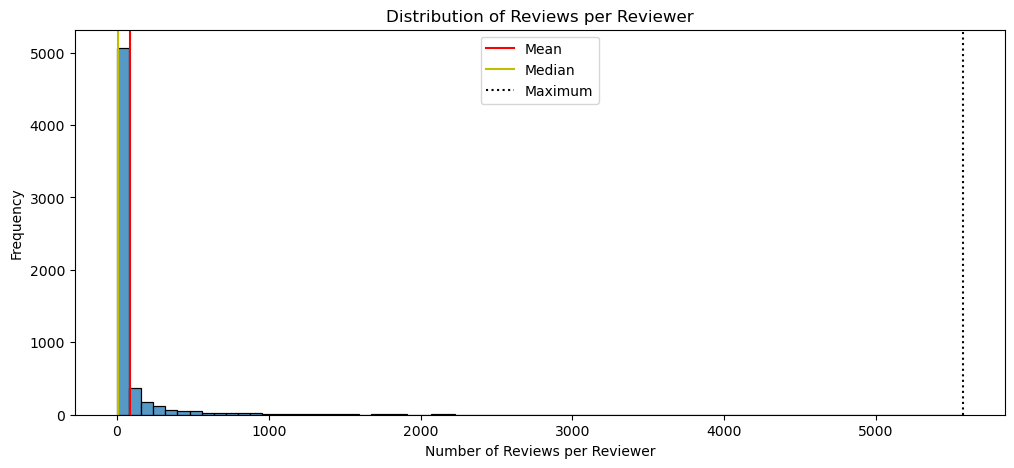

In [10]:
plt.figure(figsize = (12,5))
sns.histplot(critics_df['Reviews'], bins = 70)
plt.axvline(critics_df['Reviews'].mean(), color = 'r', label = 'Mean')
plt.axvline(critics_df['Reviews'].median(), color = 'y', label = 'Median')
plt.axvline(critics_df['Reviews'].max(), color = 'k', linestyle = ':', label = 'Maximum')

#labels
plt.title('Distribution of Reviews per Reviewer')
plt.ylabel('Frequency')
plt.xlabel('Number of Reviews per Reviewer')
plt.legend(loc = 'upper center')
plt.show()

The above histogram shows that the majority of the reviewers have given around 0-100 reviews, with any providing over 1000 seeming to be in the minority although likely to offer insight on a wide range of movies. Based on these findings, and the logic required to make recommendations based on user preferences, the list of reviewers will now be filtered. This fitlering will include the following:

|Action|Reasoning|
|-|-|
|Drop all reviewers who reviewed less than 10 movies|Does not offer enough variety in review content|

This filtering is applied below by first creating a new critics dataframe, then updating the original `small_df` to only include the reviews made by the reviewers within this filtered list. 

In [11]:
#all critics who reviewed between 10 and 1000 movies
filtcritics_df = critics_df[(critics_df['Reviews'] >= 10)]

As before, the statistical information for the number of reviews is shown both in a table and in a second histogram below.

In [12]:
#statistical info
filtcritics_df.describe()

,Reviews
count,2555.000000
mean,208.391389
std,437.128920
min,10.000000
25%,20.500000
50%,56.000000
75%,188.000000
max,5569.000000


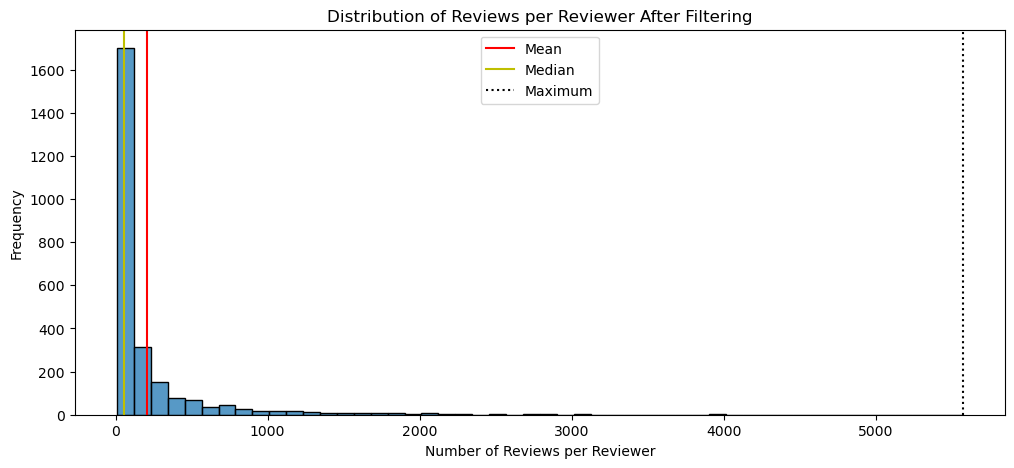

In [13]:
# plot figure
plt.figure(figsize = (12,5))
sns.histplot(filtcritics_df['Reviews'], bins = 50)
plt.axvline(filtcritics_df['Reviews'].mean(), color = 'r', label = 'Mean')
plt.axvline(filtcritics_df['Reviews'].median(), color = 'y', label = 'Median')
plt.axvline(filtcritics_df['Reviews'].max(), color = 'k', linestyle = ':', label = 'Maximum')

#labels
plt.title('Distribution of Reviews per Reviewer After Filtering')
plt.ylabel('Frequency')
plt.xlabel('Number of Reviews per Reviewer')
plt.legend(loc = 'upper center')
plt.show()

Although the above histogram is still showing a large right skew within the data, the overall distribution above is improved on the original reviewer information, however still providing a high number of reviewers with which to carry out the analysis.

In [14]:
print(f'There are {filtcritics_df.shape[0]} reviewers who reviewed more than 10 movies.')

There are 2555 reviewers who reviewed more than 10 movies.


The reviews dataset is now filtered to contain only these names below.

In [15]:
# new dataset of filtered reviews
smallrev_df = small_df[small_df['critic_name'].isin(filtcritics_df['critic_name'])]
smallrev_df.head()

,rotten_tomatoes_link,critic_name,final_score
3,m/0814255,Ben McEachen,0.70
6,m/0814255,Nick Schager,0.25
7,m/0814255,Bill Goodykoontz,0.70
9,m/0814255,Jim Schembri,0.60
10,m/0814255,Mark Adams,0.80


In [16]:
print(f'There are {smallrev_df.shape[0]} reviews in total by reviewers reviewed between 10 and 1000 movies.')

There are 532440 reviews in total by reviewers reviewed between 10 and 1000 movies.


## 1.3 Filter Movies
In a similar manner, the distribution of reviews within the movies will also be assessed, now taking into account only the movies that are remaining after the reviewer filtering. The top movies, statistical information and distribution are shown below.

In [17]:
# create a df of movie counts remaining within the df once revewers have been filtered
movielink_df = pd.DataFrame(smallrev_df['rotten_tomatoes_link'].value_counts()).reset_index()

#rename columns
movielink_df.columns = ['rotten_tomatoes_link', 'Reviews']

# top five most common movies
movielink_df.head()

,rotten_tomatoes_link,Reviews
0,m/joker_2019,303
1,m/once_upon_a_time_in_hollywood,292
2,m/avengers_endgame,290
3,m/captain_marvel,290
4,m/us_2019,281


In [18]:
# statistical information
movielink_df.describe()

,Reviews
count,17451.000000
mean,30.510572
std,40.189456
min,1.000000
25%,5.000000
50%,12.000000
75%,39.000000
max,303.000000


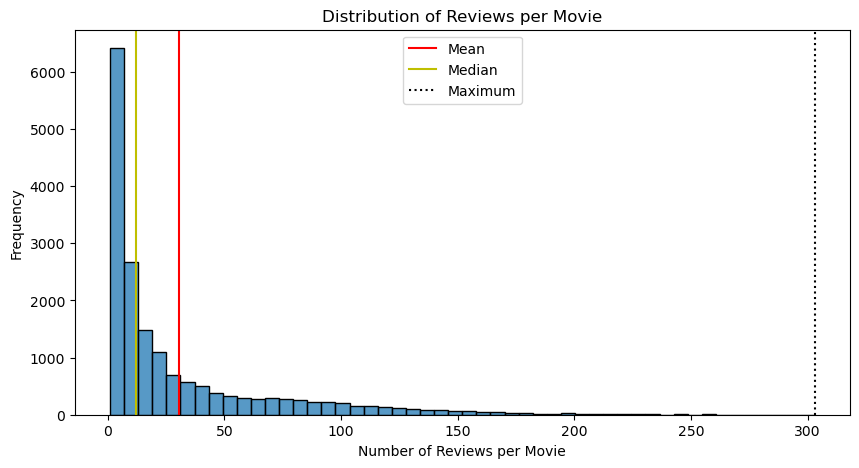

In [19]:
# plot figure
plt.figure(figsize = (10,5))
sns.histplot(movielink_df['Reviews'], bins = 50)
plt.axvline(movielink_df['Reviews'].mean(), color = 'r', label = 'Mean')
plt.axvline(movielink_df['Reviews'].median(), color = 'y', label = 'Median')
plt.axvline(movielink_df['Reviews'].max(), color = 'k', linestyle = ':', label = 'Maximum')

#labels
plt.title('Distribution of Reviews per Movie')
plt.ylabel('Frequency')
plt.xlabel('Number of Reviews per Movie')
plt.legend(loc = 'upper center')
plt.show()

This shows that there is also a right skew to this data, however the overall range in the number of reviews is not as extreme as for the reviewers themselves. For this reason, another bottom end filter will be applied, to only filter out the movies which have been reviewed fewer than 10 times, as this is not considered to be enough to provide enough information on the similarity of a movie. This filtering is applied and visualised below.

In [20]:
#all movies reviewed at least 10 times
filtlinks_df = movielink_df[(movielink_df['Reviews'] >= 10)]

In [21]:
# statistical information
filtlinks_df.describe()

,Reviews
count,9973.000000
mean,50.015943
std,43.981301
min,10.000000
25%,17.000000
50%,32.000000
75%,73.000000
max,303.000000


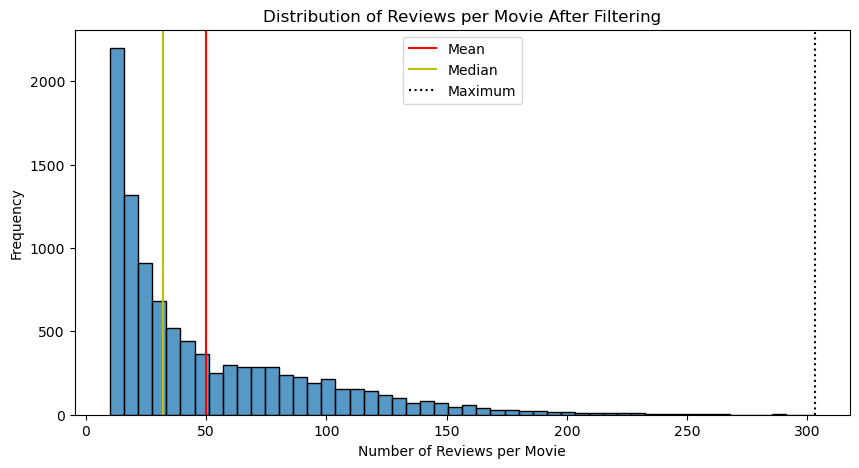

In [22]:
# plot figure
plt.figure(figsize = (10,5))
sns.histplot(filtlinks_df['Reviews'], bins = 50)
plt.axvline(filtlinks_df['Reviews'].mean(), color = 'r', label = 'Mean')
plt.axvline(filtlinks_df['Reviews'].median(), color = 'y', label = 'Median')
plt.axvline(filtlinks_df['Reviews'].max(), color = 'k', linestyle = ':', label = 'Maximum')

#labels
plt.title('Distribution of Reviews per Movie After Filtering')
plt.ylabel('Frequency')
plt.xlabel('Number of Reviews per Movie')
plt.legend(loc = 'upper center')
plt.show()

In [23]:
print(f'There are {filtlinks_df.shape[0]} movies reviewed at least 10 times.')

There are 9973 movies reviewed at least 10 times.


With the movies also now filtered, a final `revs_df` dataframe is created including only the reviews related to these movies, while also taking into account the filtering from the reviewers themselves. This is defined below.

In [24]:
revs_df = smallrev_df[smallrev_df['rotten_tomatoes_link'].isin(filtlinks_df['rotten_tomatoes_link'])]
revs_df.head()

,rotten_tomatoes_link,critic_name,final_score
3,m/0814255,Ben McEachen,0.70
6,m/0814255,Nick Schager,0.25
7,m/0814255,Bill Goodykoontz,0.70
9,m/0814255,Jim Schembri,0.60
10,m/0814255,Mark Adams,0.80


In [25]:
print(f'There are {revs_df.shape[0]} reviews remaining once these have been filtered for both reviewers and movies.')

There are 498809 reviews remaining once these have been filtered for both reviewers and movies.


## 1.3 Assign IDs
The numeric ids for critics and movies can now be assigned in order to continue with the definition of the recommender systems. This is done via *Label Encoding*, where an encoder model is fit to both the `critic_name` and `movie_id` column to convert these into numeric values, in both cases assigning a new column to contain these ids. This is carried out below.

In [26]:
# use label encoding to assign numeric values to both columns
le = LabelEncoder()
# Assigning numerical values and storing in another column
revs_df['critic_id'] = le.fit_transform(revs_df['critic_name'])
revs_df['movie_id'] = le.fit_transform(revs_df['rotten_tomatoes_link'])

# sanity check
revs_df.head()

,rotten_tomatoes_link,critic_name,final_score,critic_id,movie_id
3,m/0814255,Ben McEachen,0.70,237,0
6,m/0814255,Nick Schager,0.25,1842,0
7,m/0814255,Bill Goodykoontz,0.70,267,0
9,m/0814255,Jim Schembri,0.60,1111,0
10,m/0814255,Mark Adams,0.80,1577,0


In [27]:
# sanity check
revs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498809 entries, 3 to 1129975
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  498809 non-null  object 
 1   critic_name           498809 non-null  object 
 2   final_score           498809 non-null  float64
 3   critic_id             498809 non-null  int32  
 4   movie_id              498809 non-null  int32  
dtypes: float64(1), int32(2), object(2)
memory usage: 19.0+ MB


Now that the reviews have been filtered, a new movie dataframe must be generated that contains only the movies remaining within this list of filtered reviews. This is created below.

In [28]:
# filter and re-number movies based on revs_df content
filtmovies_df = fullmovies_df[fullmovies_df['rotten_tomatoes_link'].isin(revs_df['rotten_tomatoes_link'])].reset_index()
filtmovies_df.head()

,index,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


The label encoder is then applied to the `rotten_tomatoes_link` column within the filtered movies dataframe, in order to assign the same movie ids as are within the filtered reviews dataset.

In [29]:
# apply label encoder
filtmovies_df['movie_id'] = le.fit_transform(filtmovies_df['rotten_tomatoes_link'])

# sanity check
filtmovies_df.head(3)

,index,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,movie_id
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,0
1,1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",...,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19,1
2,2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",...,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8,2


In [30]:
# sanity check 2
filtmovies_df.tail(3)

,index,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,movie_id
9970,17705,m/zoolander_2,Zoolander 2,Former models Derek Zoolander (Ben Stiller) an...,Zoolander No. 2 has more celebrity cameos than...,PG-13,Comedy,Ben Stiller,"Nicholas Stoller, John Hamburg, Ben Stiller, J...","Ben Stiller, Owen Wilson, Will Ferrell, Penelo...",...,Rotten,22.0,232.0,Spilled,20.0,41745.0,48,51,181,9970
9971,17706,m/zoom_2006,Zoom,"Capt. Zoom, or Jack (Tim Allen), as he is now ...",Lacking the punch and good cheer of The Incred...,PG,"Action & Adventure, Comedy, Kids & Family",Peter Hewitt,"Adam Rifkin, David Berenbaum","Tim Allen, Courteney Cox, Chevy Chase, Spencer...",...,Rotten,4.0,68.0,Spilled,33.0,11369.0,19,3,65,9971
9972,17708,m/zootopia,Zootopia,From the largest elephant to the smallest shre...,The brilliantly well-rounded Zootopia offers a...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","J.K. Simmons, Kristen Bell, Octavia Spencer, A...",...,Certified-Fresh,98.0,291.0,Upright,92.0,101511.0,50,285,7,9972


Due to the nature of the datasets and how they are ordered, this new `movie_id` column is aligned with the index of the dataframe. The overall contents of this dataframe can be seen below.

In [31]:
# review contents of df
filtmovies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   index                             9973 non-null   int64  
 1   rotten_tomatoes_link              9973 non-null   object 
 2   movie_title                       9973 non-null   object 
 3   movie_info                        9893 non-null   object 
 4   critics_consensus                 8440 non-null   object 
 5   content_rating                    9973 non-null   object 
 6   genres                            9971 non-null   object 
 7   directors                         9867 non-null   object 
 8   authors                           9309 non-null   object 
 9   actors                            9847 non-null   object 
 10  original_release_date             9724 non-null   object 
 11  streaming_release_date            9871 non-null   object 
 12  runtim

Although there are missing values within this dataset, the columns for `rotten_tomatoes_link` and `movie_title` are all fully populated, and as these are the most important columns to use within the recommender system there is no need to drop any of the remaining data.

# 3 Collaborative Recommender System
The first recommender system that will be highlighted here is a *Collaborative Recommender System*, which will recommend the top movies for a specific user based on their historical interests (in this case, previous ratings).

## 3.1 Matrix Generation
The collaborative recommender system will be created using the **FunkSVD** package, which generates two matrices, one for the Movies (M) and one for the Reviewers (U), and uses these to approximate the rating a specific user would give a specific movie. These matrices are generated by looking at the ratings that already exist between the reviewers and movies, and forming two matrices that output these values when multiplied together.
The first stage in building a FunkSVD model is to generate a basic dataframe containing only the `critic_id`, `movie_id` and `final_score`. 

In [32]:
# create simplified reviews df for funk SVD
funk_df = revs_df[['critic_id', 'movie_id', 'final_score']].sort_values(by=['critic_id', 'movie_id'])
funk_df.head()

,critic_id,movie_id,final_score
86802,0,997,0.2
99059,0,1120,0.2
99467,0,1125,0.2
105265,0,1187,0.4
111206,0,1252,0.6


In order to complete a FunkSVD model accurately, these scores will then be converted to become integers between 1 and 5.

In [33]:
funk_df['final_score'] = round((1 + (4 * funk_df['final_score']))+0.01,0)
funk_df.head()

,critic_id,movie_id,final_score
86802,0,997,2.0
99059,0,1120,2.0
99467,0,1125,2.0
105265,0,1187,3.0
111206,0,1252,3.0


With the simplified dataframe completed, the *surprise* dataset (used to carry out the FunkSVD model) is generated below then divided using a test/train split.

In [34]:
# define surprise dataset and apply test/train split
movie_data = Dataset.load_from_df(funk_df, Reader(rating_scale=(1, 5)))
train_dataset, test_dataset = train_test_split(movie_data, test_size=0.3)

The FunkSVD model is generated using the method shown below, where the hyperparameter of `n_factors` is first optimised to the *Fraction of Concordant Pairs* (FCP) metric, which is generally considered as one of the best ways for ranking user intent within a collaborative recommendation system. The number of factors is iterated over two iterations of `n_epochs` below to see how this impacts the result.

In [145]:
# define empty list for FCP scores
FCP_pred = []
# range for different n_factors
fact = range(20,410,50)

# loop through factors within FunkSVD model
for n in fact:
    #1. Instantiate
    loop_algorithm = FunkSVD(n_factors=n, 
                           n_epochs=100, # initial number of epochs
                           lr_all=0.1,    
                           biased=False,  
                           verbose=0)
    # 2. fit
    loop_algorithm.fit(train_dataset)
    # 3. predict
    loop_predictions = loop_algorithm.test(test_dataset)
    # calculate FCP value
    loop_FCP = accuracy.fcp(loop_predictions, verbose=False)
    # add to list
    FCP_pred.append(loop_FCP)

In [158]:
# define empty list for FCP scores
FCP_pred2 = []
# range for different n_factors
fact = range(20,410,50)

# loop through factors within FunkSVD model
for n in fact:
    #1. Instantiate
    loop_algorithm2 = FunkSVD(n_factors=n, 
                           n_epochs=50, 
                           lr_all=0.1,    # Learning rate for each epoch
                           biased=False,  # This forces the algorithm to store all latent information in the matrices
                           verbose=0)
    # 2. fit
    loop_algorithm2.fit(train_dataset)
    # 3. predict
    loop_predictions2 = loop_algorithm2.test(test_dataset)
    # calculate FCP value
    loop_FCP2 = accuracy.fcp(loop_predictions2, verbose=False)
    # add to list
    FCP_pred2.append(loop_FCP2)

The hyperparameter optimisation is plotted in the graph below.

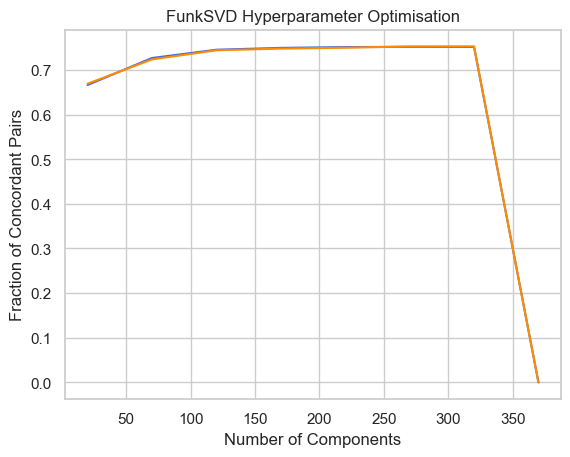

In [168]:
# plot FCP
plt.figure()
sns.set_theme(style="whitegrid")
plt.plot(fact, FCP_pred, color = 'royalblue', label = '100 Epochs')
plt.plot(fact, FCP_pred2, color = 'darkorange', label = '50 Epochs')
plt.title('FunkSVD Hyperparameter Optimisation')
plt.ylabel('Fraction of Concordant Pairs')
plt.xlabel('Number of Components')
plt.legend()
plt.show()

The FCP score stops increasing after around 150 components, so this is taken as the optimal hyperparemetr in this case. The optimised FunkSVD model is generated below, with the various evaluation metrics then calculated.

In [167]:
# instatitate funkSVD model
my_algorithm = FunkSVD(n_factors=150, 
                       n_epochs=50, 
                       lr_all=0.1,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=0)     # no need for text output

# fit model
my_algorithm.fit(train_dataset)

In [169]:
# calculate metrics for FunkSVD - 100, 50

predictions = my_algorithm.test(test_dataset)
RMSE = accuracy.rmse(predictions, verbose=False)
MSE = accuracy.mse(predictions, verbose=False)
MAE = accuracy.mae(predictions, verbose=False)
FCP = accuracy.fcp(predictions, verbose=False)

# output results
print(f'Root Mean Square Error: {RMSE:.3f}')
print(f'Mean Squared Error: {MSE:.3f}')
print(f'Mean Absolute Error: {MAE:.3f}')
print(f'FCP: {FCP:.3f}')

Root Mean Square Error: 0.700
Mean Squared Error: 0.489
Mean Absolute Error: 0.549
FCP: 0.770


The evaluation metrics, particularly the FCP, are defining appropriate levels for this model, therefore this will now be used for the remainder of the Collaborative Recommender System generation. The overall accuracy of the model will be easier to observe from the output of the recommender system that is created, and comparing the movies that are suggested with those that have previously been rated highly by the user in question.

The User and Movie matrices are defined from the output of this optimised model below.

In [170]:
# user matrix
U = my_algorithm.pu

# movie matrix
M = my_algorithm.qi.T

print(f'User matrix has {U.shape[0]} rows and {U.shape[1]} columns.')
print(f'Movie matrix has {M.shape[0]} rows and {M.shape[1]} columns.')

User matrix has 2553 rows and 150 columns.
Movie matrix has 150 rows and 9973 columns.


## 3.2 Recommender System Generation
The collaborative recommender system is created by calculating the predicted ratings for each movie for a defined user, then outputting the movies with the highest ratings. 
These ratings are estimated by multiplying the two matrices together, however only looking at one user at a time in order to reduce the computational cost.
Using information previously gained from the Content Based Recommender System in a previous notebook, the collaborative recommender is generated below.

In [171]:
def collab_recommender(critic_id, ratings = 'top', rotten = True, n = 10):

    """
    This function is used to run the user based collaborative recommender system.
    The purpose of this system is for the user to input the id of a criic within the database, and the function will
    output the top/bottom n movies for that used, based on predicted ratings.
    
    Parameters:
    -----------
    
    critic_id:  ID number of critic to be assessed
    ratings:    Which output of estimated ratings should be provided
                Either 'top' or 'bottom'
                'top' = highest rated movies
                'bottom' = lowest rated movies
    n:      How many movies should be recommended
            Default = 10
    rotten: Boolean input on whether Rotten movies should be included in the recommendations
            Default = True (Rotten movies will be included)
            
    Returns:
    -------
    
    top_movies: Top 10 highest predicted rating movies movies for the given critic, based on historical ratings.
    
    Other Outputs:
    --------
    
    Critic Name: Name of the critic defined by the ID number input
    
    Number of Reviews: Total number of reviews that critic has given
    
    Favourite Movies: Top 5 previously rated movies by the defined critic
    
    Least Favourite Movies: Bottom 5 previously rated movies by the defined critic
        
    """
       
    # find matrix related to specific user ID
    inner_user_id = train_dataset.to_inner_uid(critic_id) # find the inner representation of defined user id
    user_pr = U[inner_user_id]
    
    # calculate rating for all movies by this user
    user_ratings = np.dot(user_pr, M)
    
    #create dataframe of findings
    user_ratings_df = pd.DataFrame(
                               {'Movie Title': filtmovies_df['movie_title'],
                                'Description': filtmovies_df['movie_info'],
                                'Genres': filtmovies_df['genres'],
                                'Rating': filtmovies_df['tomatometer_status'],
                                'Release Date': filtmovies_df['original_release_date'],
                                'Expected Rating':user_ratings})
    
    # find critic name
    critic_name = revs_df[revs_df['critic_id']==critic_id].iloc[0,1]
    
    # find ids and names of previously highly rated movies
    prev_movies = list(revs_df[revs_df['critic_id']==critic_id].sort_values('final_score', ascending = False)['movie_id'])
    critic_movies_l = list(filtmovies_df.iloc[prev_movies,2])
    critic_movies = ', '.join(critic_movies_l[0:6])
    
    # find ids and names of previously low rated movies
    bad_movies = list(revs_df[revs_df['critic_id']==critic_id].sort_values('final_score')['movie_id'])
    critic_moviesn_l = list(filtmovies_df.iloc[bad_movies,2])
    critic_moviesn = ', '.join(critic_moviesn_l[0:6])
    #revs_df[revs_df['critic_name']=='Larry Carroll'].sort_values('final_score', ascending = False).head(10)
    
    # printing selected critic name and top and bottom previously rated movies
    print(f'Critic Name: \033[1m{critic_name}\033[0;0m')
    print(f'Number of Reviews: \033[1m{len(prev_movies)}\033[0;0m')
    print(f'Favourite Movies:  {critic_movies}')
    print(f'Least Favourite Movies:  {critic_moviesn}')
    
    if rotten == True:
        top_ratings = user_ratings_df.sort_values('Expected Rating', ascending = False)
        bottom_ratings = user_ratings_df.sort_values('Expected Rating')
    else:    
        top_ratings = user_ratings_df[user_ratings_df['Rating']!='Rotten'].sort_values('Expected Rating', ascending = False)
        bottom_ratings = user_ratings_df[user_ratings_df['Rating']!='Rotten'].sort_values('Expected Rating')
    
    if ratings == 'top':
        return top_ratings.iloc[:,:5].head(n)
    
    elif ratings == 'bottom':
        return bottom_ratings.iloc[:,:5].head(n)
    
    else:
        return print('Select rating range of either \'top\' or \'bottom\'')

The recommender system has been tested below using a random input critic id number, in this case **123**.

In [187]:
# testing with an unknown user
collab_recommender(123)

Critic Name: Amy Rowe
Number of Reviews: 11
Favourite Movies:  Call Me by Your Name, In a Valley of Violence, Lady Bird, Goat, Paterson, Split
Least Favourite Movies:  The Fate of the Furious, Equity, Saban's Power Rangers, Snatched, Split, The Intervention


,Movie Title,Description,Genres,Rating,Release Date
4667,Intimate Strangers,When a beautiful woman named Anna (Sandrine Bo...,"Art House & International, Comedy, Drama, Myst...",Certified-Fresh,2003-01-01
4727,It's Kind of a Funny Story,"Stressed by adolescence, 16-year-old Craig Gil...","Comedy, Drama",Rotten,2010-10-08
4724,Italian for Beginners,"""Italian for Beginners"" follows the stories of...","Art House & International, Comedy, Drama, Romance",Certified-Fresh,2001-09-01
106,The Road,"America is a grim, gray shadow of itself after...","Drama, Mystery & Suspense, Science Fiction & F...",Certified-Fresh,2009-11-25
7667,Starfish,A woman grieves over the loss of her best frie...,"Drama, Horror, Science Fiction & Fantasy",Fresh,2019-03-13
2888,The Dead Zone,When Johnny Smith (Christopher Walken) awakens...,"Horror, Mystery & Suspense, Science Fiction & ...",Certified-Fresh,1983-10-21
6100,Never Been Kissed,"Josie Geller (Drew Barrymore), a baby-faced ju...",Comedy,Rotten,1999-04-09
5576,Marathon Man,"Thomas ""Babe"" Levy (Dustin Hoffman) is a Colum...","Drama, Mystery & Suspense",Fresh,1976-10-06
5112,Last Chance Harvey,"In London for his daughter's wedding, a strugg...","Drama, Romance",Certified-Fresh,2009-01-16
7548,Soul Power,"In Zaire, James Brown, B.B. King, Miriam Makeb...","Documentary, Musical & Performing Arts",Certified-Fresh,2009-07-10


The above user seems to like international and independent movies based on their history (and doesnt like action and sci-fi), which aligns with a large proportion of the recommended movies that are provided. In order to test the system further, pre-defined users with known likes/dislikes will be input, based on the function that was created in a previous notebook (*Data Wrangling*).

## 3.3 Testing the System
The following list of users have been found in a previous notebook, with the average scores of their previous reviews implying the following interests they have in specific movie genres:

|Name|Likes|Dislikes|
|-|-|-|
|Sarah Chauncey|Romance, Drama| Horror|
|Stefan Birgir Stefansson|Action, Documentary| International|
|Gary Brown|Family, Documentary| Horror|
|Larry Carroll|Comedy| Horror|
|R. Kurt Osenlund|Horror, International|Fantasy|
|Toby Young|Drama, Mystery|Fantasy|
|David Blaustein|Fantasy, Mystery|Romance|
|Brandon Judell|International|Fantasy|
|Jack Blackwell| Drama |Romance, Action|

The id's corresponding to these users are found below.

In [315]:
# list of names to be found
cr_names = ['Sarah Chauncey','Stefan Birgir Stefansson','Gary Brown', 'Larry Carroll', \
             'R. Kurt Osenlund', 'Toby Young', 'David Blaustein', 'Brandon Judell','Jack Blackwell']
cr_ids = []

# loop through names to add id to the list
for c in cr_names:
    cr_id = revs_df[revs_df['critic_name']==c]['critic_id'].unique()
    cr_ids.append(cr_id[0])

# create df of names and ids
cr_options = pd.DataFrame({'Name': cr_names, 
                           'ID': cr_ids})    
display(cr_options)

,Name,ID
0,Sarah Chauncey,2176
1,Stefan Birgir Stefansson,2285
2,Gary Brown,815
3,Larry Carroll,1429
4,R. Kurt Osenlund,1985
5,Toby Young,2410
6,David Blaustein,594
7,Brandon Judell,306
8,Jack Blackwell,947


The fully populated table for the critic names, their interests, and the id input for the recommender system is shown below.

|Name|Likes|Dislikes|ID
|-|-|-|-|
|Sarah Chauncey|Romance, Drama| Horror|2176|
|Stefan Birgir Stefansson|Action| International|2285|
|Gary Brown|Family, Documentary| Horror|815|
|Larry Carroll|Comedy| Horror|1429|
|R. Kurt Osenlund|Horror, International|Fantasy|1985|
|Toby Young|Drama, Mystery|Fantasy|2410|
|David Blaustein|Fantasy, Mystery|Romance|594|
|Brandon Judell|International|Fantasy|306|
|Jack Blackwell| Drama |Romance, Action|947|

These can now be used as example for finding movies based on users with similar interests. See the example of *Sarah Chauncey* below.

In [316]:
collab_recommender(2176)

Critic Name: Sarah Chauncey
Number of Reviews: 122
Favourite Movies:  The Times of Harvey Milk, Broadcast News, Thirteen, Hotel Rwanda, Dead Poets Society, Ordinary People
Least Favourite Movies:  Taxi, The Honeymooners, My Boss's Daughter, Soul Plane, Timeline, AVP - Alien Vs. Predator


,Movie Title,Description,Genres,Rating,Release Date
9524,Waiting,Staffers at the restaurant Shenaniganz engage ...,Comedy,Rotten,2005-10-07
3792,Garden State,"After many years away, television bit part act...","Comedy, Drama, Romance",Certified-Fresh,2004-07-28
4356,The Horse Whisperer,When teenage Grace (Scarlett Johansson) is tra...,"Drama, Western, Romance",Fresh,1998-05-15
4024,The Greatest Game Ever Played,Blue-collar Francis Ouimet (Shia LaBeouf) figh...,Drama,Fresh,2005-09-30
4180,Hateship Loveship,A shy caretaker (Kristen Wiig) believes that t...,"Comedy, Drama",Rotten,2014-04-11
830,Step Brothers,Brennan Huff (Will Ferrell) and Dale Doback (J...,Comedy,Rotten,2008-07-25
9323,Tyler Perry's A Fall from Grace,When a woman is indicted for murdering her hus...,Mystery & Suspense,Rotten,NaN
854,Hofshat Kaits (My Father My Lord),The leader of a small ultra-orthodox community...,"Art House & International, Drama",Fresh,2008-07-11
2275,But I'm a Cheerleader,Megan (Natasha Lyonne) considers herself a typ...,Comedy,Rotten,2000-06-23
5035,Kumaré,Lapsed Hindu Vikram Gandhi conducts an experim...,"Documentary, Drama, Special Interest",Fresh,2012-06-20


In [317]:
collab_recommender(2176, ratings = 'bottom')

Critic Name: Sarah Chauncey
Number of Reviews: 122
Favourite Movies:  The Times of Harvey Milk, Broadcast News, Thirteen, Hotel Rwanda, Dead Poets Society, Ordinary People
Least Favourite Movies:  Taxi, The Honeymooners, My Boss's Daughter, Soul Plane, Timeline, AVP - Alien Vs. Predator


,Movie Title,Description,Genres,Rating,Release Date
158,Fame,"At New York's High School of Performing Arts, ...","Drama, Musical & Performing Arts, Romance",Rotten,2009-09-25
5100,Lantana,Plagued with grief over the murder of her daug...,"Drama, Mystery & Suspense",Certified-Fresh,2002-01-25
3589,The Fisher King,After shock jock Jack Lucas (Jeff Bridges) ina...,"Comedy, Drama, Science Fiction & Fantasy",Certified-Fresh,1991-09-20
21,Saint Ralph,The year 1954 finds teen outcast Ralph Walker ...,"Comedy, Drama",Fresh,2005-08-05
5973,Murder on the Orient Express,"Having concluded a case, detective Hercule Poi...",Mystery & Suspense,Fresh,1974-11-22
8087,The Believer,A little knowledge is a dangerous thing -- an ...,Drama,Certified-Fresh,2002-04-01
4453,I Am A Sex Addict,"As he prepares to wed for the third time, a ma...","Art House & International, Comedy, Documentary...",Fresh,2006-04-12
8615,Dr Seuss' The Lorax,Twelve-year-old Ted (Zac Efron) lives in a pla...,"Animation, Kids & Family",Rotten,2012-03-02
8001,The Family That Preys,"Despite their differences in social class, Cha...","Comedy, Drama",Rotten,2008-09-12
7974,The Texas Chainsaw Massacre 2,Chainsaw-wielding maniac Leatherface (Bill Joh...,"Comedy, Horror",Rotten,1986-08-22


The above test shows that the recommender is generally accurate in finding movies similar to the taste of the user, however finding the correct user to be defined as the input can be difficult as it is hard to know the full extent of their interests. This is particularly the case with this dataset, as the reviewers in question are generally employed as film critics so have a wide variety in the types of movies they have watched and rated.

# 4 User Based Recommender System
## 4.1 Similarity Definition
A different form of recommender system can also be generated based on item-item similarity between all the user reviews. In order to generate this, first a utility matrix is formed which contains each of the review scores for each user and the movies they rated.

This is initiated by first creating a reduced dataframe containing only the critic and movie id's and the rating for each review.

In [230]:
# reviews df with only critic and movie id and score
userrec_df = revs_df[['critic_id', 'movie_id', 'final_score']].sort_values(by=['critic_id', 'movie_id'])

# sanity check
userrec_df.head()

,critic_id,movie_id,final_score
86802,0,997,0.2
99059,0,1120,0.2
99467,0,1125,0.2
105265,0,1187,0.4
111206,0,1252,0.6


The utility matrix is then generated using this table, resulting in a table with the critics as the index rows, and each column denoting each of the individual movies.

In [107]:
# output list of all critics and movies
critics = userrec_df['critic_id'].unique()
movies = userrec_df['movie_id'].unique()

# count number of critics and movies
num_critics = len(critics)
num_movies = len(movies)

# define R matrix of nans with critics as rows and movies as columns
R = np.full((num_critics, num_movies), np.nan)

# build user item matrix
for row in zip(userrec_df.index, userrec_df['critic_id'], userrec_df['movie_id'], userrec_df['final_score']):
    # loop through each row of the userrec_df and define list of each row values
    critic = row[1]
    movie = row[2]
    rating = row[3]
    # input rating into R matrix in the critic/movie location for each review
    R[critic-1,movie-1] = rating

# create df with of the R matrix
R_df = pd.DataFrame(data = R, index = range(1, num_critics+1), columns = range(1, num_movies+1))

R_df.head()

The utility matrix created still includes null values for all locations where the user has not rated that specific movie. These will be populated with zeros to allow for calulcation of similarities. The dataframe will also be transposed to set the index to be the `movie_id`, as this will be the input for the recommender system.

In [108]:
# fill null values with 0
R_df.fillna(0,inplace = True)
# transpose
R_df = R_df.T

# sanity check
R_df.head()

In [109]:
R_df

,1,2,3,4,5,6,7,8,9,10,...,2545,2546,2547,2548,2549,2550,2551,2552,2553,2554
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0
9970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
9972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The cosine similarity is then calculated between each of the movies, which in this instance is looking into the similarity in ratings for each movie in relation to the different users that have given it a score. The similarity matrix is created below.

In [238]:
# define similarity matrix
similarities = cosine_similarity(R_df, dense_output = False)

# sanity check
similarities.shape

(9973, 9973)

With the user based similarity matrix created, the recommender system is generated below.

## 4.2 Recommender System
Using the learning taken from generating the **Content Based Recommender System**, a recommender system based on user similarity is created below.

In [341]:
def user_recommender(title, filt = 'rating', review_threshold=50, rotten = True):
    
    """
    This function is used to run the user based recommender system.
    The purpose of this system is for the user to input the name of a movie, and the function will output the top 10 movies
    which have the highest similarity to the input, based on the historical ratings by users.
    
    Parameters:
    -----------
    
    title:  Movie Title
            Can be exact or just a small fraction of the movie title, which will be selected based on the filter provided
    filt:   Selection filter
            Either 'rating' or 'reviews'
            Defines the method used to select the film title if there are multiple results for the given input
            'ratings' = outputs the movie with the highest average rating
            'reviews' = outputs the movie with the highest number of reviews
    review_threshold: Minimum number of reviews required for the movie to be counted
            Default = 50
            Only movies which have been reviewed more times that this input will be included in the recommendations
    rotten: Boolean input on whether Rotten movies should be included in the recommendations
            Default = True (Rotten movies will be included)
            
    Returns:
    -------
    
    top_movies: Top 10 movies most similar to selected input movie, based on previous user ratings
    
    Other Outputs:
    --------
    
    Movie Title: Full title of movie defined as the input to the function
    
    Movie Description: Full description of the input movie
    
    Graph:  Graphical output of the similarity score for each of the predicted recommendations.
            Each output is coloured based on the overall classification score of the movie.
    
    """
        
    # Find the movie by the contents of the title
    # first find if there are any exact matches
    movie_exact = filtmovies_df[filtmovies_df['movie_title'] == title].index
    # then also find if there are options that contain the text from the input
    movie_options = filtmovies_df[filtmovies_df['movie_title'].str.contains(title)].index
    
    if filt == 'rating':
        multi_filter = 'tomatometer_rating'
    elif filt == 'reviews':
        multi_filter = 'tomatometer_count'
    else:
        return print('Please define a valid filter of either \'rating\' or \'reviews\'.')
    
    # there can sometimes be movies with the same title, which needs to be assessed
   
    # need to check that the movie index is able to be found with the added vote_threshold added - if not, output error
    if (len(movie_exact) == 0) & (len(movie_options) == 0):
        return print('Movie not found - please check spelling or decrease the vote_threshold')
    # now check for an exact match, as this should be used over all others
    elif len(movie_exact) == 1:
        movie_index = movie_exact[0]
    # then check if there is only one option containing the input string
    elif len(movie_exact) > 1:
        exact_index = filtmovies_df.iloc[movie_exact,:][[multi_filter]].values.argmax()
        movie_index = movie_exact[exact_index]    
    elif len(movie_options) == 1:
        movie_index = movie_options[0]        
    else:
        # if more than one movie, pick the one with the highest rating to compare against
        option_index = filtmovies_df.iloc[movie_options,:][[multi_filter]].values.argmax()
        movie_index = movie_options[option_index]
    
    # define the full title of the move that is being compared
    movie_title = filtmovies_df.iloc[movie_index,2]
    movie_rating = filtmovies_df.iloc[movie_index,14]
    
    # Create a dataframe with the movie titles
    sim_df = pd.DataFrame(
        {'Movie Title': filtmovies_df['movie_title'],
         'Description': filtmovies_df['movie_info'],
         'Release Date': filtmovies_df['original_release_date'],
         'Similarity': np.array(similarities[movie_index, :]).squeeze(),
         'Count': filtmovies_df['tomatometer_count'],
         'Rating': filtmovies_df['tomatometer_status']
        })
    
    # Get the top 10 movies with > 10 votes, not including the movie title that is being compared
    # factoring in the score of the movie
    if rotten == True:
        #including all ratings
        top_movies = sim_df[(sim_df['Count'] > review_threshold) & (sim_df['Movie Title'] != movie_title)].sort_values(by='Similarity', ascending=False).head(10)
    else:
        # not including rotten movies
        top_movies = sim_df[(sim_df['Count'] > review_threshold) & (sim_df['Movie Title'] != movie_title) & (sim_df['Rating'] != 'Rotten')].sort_values(by='Similarity', ascending=False).head(10)
    
    #define the colours based on rating
    colour_map={"Rotten":"powderblue","Fresh":"darkturquoise", "Certified-Fresh": "teal"}
    colours = [colour_map[top_movies.loc[v,"Rating"]] for v in top_movies.index]
    
    # print information on movie being compared
    print(f'Movie Name: \033[1m{movie_title}\033[0;0m')
    print(f'Movie Rating: \033[1m{movie_rating}\033[0;0m')
    print(f'Movie Description: \n{sim_df.iloc[movie_index,1]}')
    
    #plot a graph
    
    # define ylabels to prevent duplicating
    ylabel = list(top_movies['Movie Title'])
    
    plt.figure()
    sns.set_theme(style="whitegrid")
    # plot barplot with numeric y coordinates 1-10
    plt.barh(range(1,11), top_movies['Similarity'], color = colours) # assign colours based on rating
    # re-define ylabels based on ylabel list
    plt.yticks(range(1,11), ylabel)
       
        #plotting the legend
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colour_map.values()]
    plt.legend(markers, colour_map.keys(), numpoints=1, loc = 'lower right')
    
    #labels
    plt.xlabel('Similarity')
    plt.ylabel('Movie Title')
    plt.title(f'Movies Similar to {movie_title} based on Previous Ratings')
    plt.xlim((0,max(top_movies['Similarity'])+0.2))
    
    # have highest similarity movies at the top
    plt.gca().invert_yaxis()
    plt.show()
    
    return top_movies

The recommender system is tested over various film options below.

Movie Name: Harry Potter and the Deathly Hallows - Part 2
Movie Rating: Certified-Fresh
Movie Description: 
A clash between good and evil awaits as young Harry (Daniel Radcliffe), Ron (Rupert Grint) and Hermione (Emma Watson) prepare for a final battle against Lord Voldemort (Ralph Fiennes). Harry has grown into a steely lad on a mission to rid the world of evil. The friends must search for the Horcruxes that keep the dastardly wizard immortal. Harry and Voldemort meet at Hogwarts Castle for an epic showdown where the forces of darkness may finally meet their match.


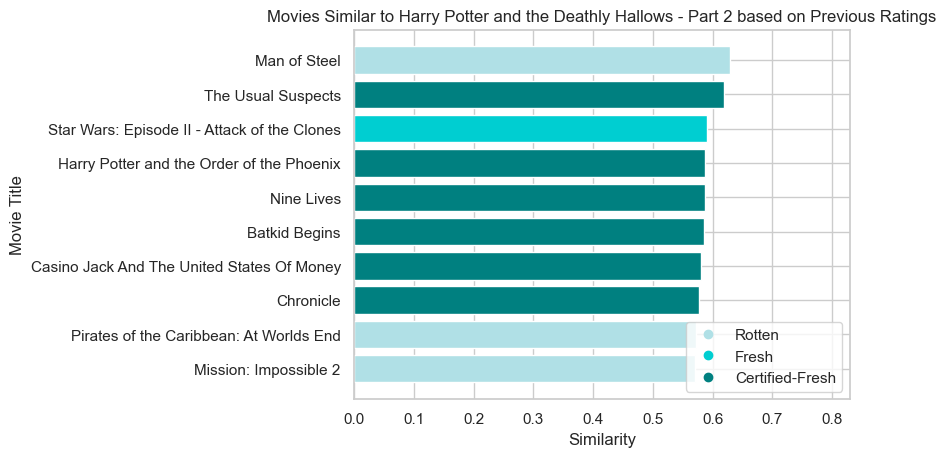

,Movie Title,Description,Release Date,Similarity,Count,Rating
7817,Man of Steel,"With the imminent destruction of Krypton, thei...",2013-06-14,0.629940,334.0,Rotten
9431,The Usual Suspects,"""The greatest trick the devil ever pulled was ...",1995-08-16,0.618375,76.0,Certified-Fresh
7659,Star Wars: Episode II - Attack of the Clones,"Set ten years after the events of ""The Phantom...",2002-05-16,0.591287,253.0,Fresh
4169,Harry Potter and the Order of the Phoenix,"Now in his fifth year at Hogwarts, Harry (Dani...",2007-07-11,0.586610,255.0,Certified-Fresh
727,Nine Lives,The lives of nine women occasionally overlap a...,2005-10-14,0.586550,85.0,Certified-Fresh
1755,Batkid Begins,The Make-A-Wish Foundation and the city of San...,2015-06-26,0.585917,60.0,Certified-Fresh
2360,Casino Jack And The United States Of Money,This documentary tracks the high life and even...,2010-05-07,0.580121,66.0,Certified-Fresh
2495,Chronicle,"Andrew (Dane DeHaan) is a socially awkward, in...",2012-02-03,0.577470,185.0,Certified-Fresh
6594,Pirates of the Caribbean: At Worlds End,Will Turner (Orlando Bloom) and Elizabeth Swan...,2007-05-25,0.571852,228.0,Rotten
5823,Mission: Impossible 2,Tom Cruise returns to his role as Ethan Hunt i...,2000-12-31,0.570994,151.0,Rotten


In [342]:
user_recommender("Harry Potter")

Movie Name: Frozen
Movie Rating: Certified-Fresh
Movie Description: 
When their kingdom becomes trapped in perpetual winter, fearless Anna (Kristen Bell) joins forces with mountaineer Kristoff (Jonathan Groff) and his reindeer sidekick to find Anna's sister, Snow Queen Elsa (Idina Menzel), and break her icy spell. Although their epic journey leads them to encounters with mystical trolls, a comedic snowman (Josh Gad), harsh conditions, and magic at every turn, Anna and Kristoff bravely push onward in a race to save their kingdom from winter's cold grip.


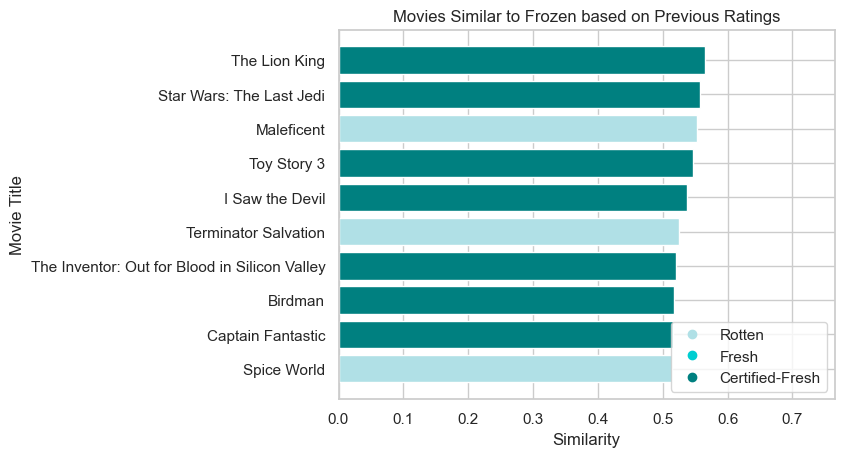

,Movie Title,Description,Release Date,Similarity,Count,Rating
8597,The Lion King,This Disney animated feature follows the adven...,1994-06-15,0.564781,129.0,Certified-Fresh
7663,Star Wars: The Last Jedi,Luke Skywalker's peaceful and solitary existen...,2017-12-15,0.557827,473.0,Certified-Fresh
5522,Maleficent,"As a beautiful young woman of pure heart, Male...",2014-05-30,0.552251,270.0,Rotten
9203,Toy Story 3,With their beloved Andy preparing to leave for...,2010-06-18,0.546045,307.0,Certified-Fresh
1311,I Saw the Devil,"On a dark road, taxi driver Kyung-chul (Min-si...",2011-03-04,0.536642,85.0,Certified-Fresh
7961,Terminator Salvation,"Although Judgment Day has in fact occurred, th...",2009-05-21,0.525106,280.0,Rotten
8510,The Inventor: Out for Blood in Silicon Valley,With a new invention that promised to revoluti...,NaN,0.520782,60.0,Certified-Fresh
1953,Birdman,Former cinema superhero Riggan Thomson (Michae...,2014-10-17,0.517564,352.0,Certified-Fresh
2329,Captain Fantastic,"Ben Cash (Viggo Mortensen), his wife Leslie an...",2016-07-08,0.515621,225.0,Certified-Fresh
7590,Spice World,"Hang on to your knickers, pump up your platfor...",1998-01-23,0.513583,64.0,Rotten


In [343]:
user_recommender("Frozen")

Movie Name: Kill Bill: Volume 1
Movie Rating: Certified-Fresh
Movie Description: 
A former assassin, known simply as The Bride (Uma Thurman), wakes from a coma four years after her jealous ex-lover Bill (David Carradine) attempts to murder her on her wedding day. Fueled by an insatiable desire for revenge, she vows to get even with every person who contributed to the loss of her unborn child, her entire wedding party, and four years of her life. After devising a hit list, The Bride sets off on her quest, enduring unspeakable injury and unscrupulous enemies.


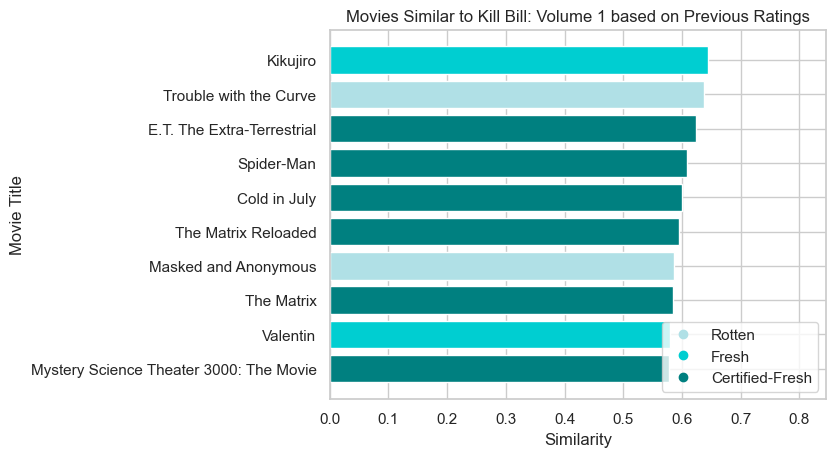

,Movie Title,Description,Release Date,Similarity,Count,Rating
4948,Kikujiro,Masao (Yusuke Sekiguchi) is a lonely 9-year-ol...,NaN,0.645018,51.0,Fresh
9261,Trouble with the Curve,For decades Gus Lobel (Clint Eastwood) has bee...,2012-09-21,0.638144,204.0,Rotten
3355,E.T. The Extra-Terrestrial,After a gentle alien becomes stranded on Earth...,1982-06-11,0.623812,130.0,Certified-Fresh
7594,Spider-Man,"""Spider-Man"" centers on student Peter Parker (...",2002-05-03,0.609040,245.0,Certified-Fresh
2597,Cold in July,The killing of a home intruder puts a Texas ma...,2014-05-23,0.600259,115.0,Certified-Fresh
5637,The Matrix Reloaded,"Freedom fighters Neo (Keanu Reeves), Trinity (...",2003-05-07,0.594443,245.0,Certified-Fresh
5627,Masked and Anonymous,A nation wracked with civil war and social unr...,2003-07-25,0.585881,82.0,Rotten
5636,The Matrix,Neo (Keanu Reeves) believes that Morpheus (Lau...,1999-03-31,0.585091,154.0,Certified-Fresh
699,Valentin,A 9-year-old (Rodrigo Noya) stays with his wid...,2004-05-07,0.579058,67.0,Fresh
6042,Mystery Science Theater 3000: The Movie,Dr. Clayton Forrester (Trace Beaulieu) figures...,1996-04-19,0.578162,55.0,Certified-Fresh


In [346]:
user_recommender("Kill Bill")

The above shows that the recommender system seems to be able to predict some movies that are to be expected based on the given input, however there also seem to be outliers in what is being recommended.

This is likely due to the nature of the Rotten Tomatoes dataset itself, where a large number of the critics are professional film reviewers so are unlikely to have strong opinions to provide accurate similarity scores.

# 5 Next Steps
This is the final notebook related to the Movie Recommendation project at this stage, and has successfully produced two recommender systems based on user ratings which will be incorporated into the *Streamlit App* mentioned previously. However, due to the nature of the *Rotten Tomatoes* dataset containing reviews made by professional film critics, the movies that are recommended can occasionally be slightly unexpected (although generally accurate). 

In the future, these can be improved by looking for other movie reviews datasets made by the average cinema go-er, as they are likely to have more specific tastes which can be monetised.

---